In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run lipm_env.ipynb #imports LIPM Env

from py_bullet_env.bullet_solo_env import SoloBulletEnv

In [2]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 2048)
        self.l2 = nn.Linear(2048, 2048)
        self.l3 = nn.Linear(2048, 1024)
        self.l4 = nn.Linear(1024, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [3]:
class DQStepper:
    def __init__(self, no_actions = 9, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        
        self.device = torch.device("cpu")
        self.dq_stepper = NN(3, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(3, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = no_actions
                
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))        
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            return np.random.randint(self.no_actions)
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:3].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,3].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,4:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,4:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,4:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 350)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

[[90.92684 ]
 [87.731476]
 [84.95569 ]
 [81.391235]
 [77.51077 ]
 [73.48483 ]
 [68.5494  ]
 [62.06688 ]
 [55.887047]
 [51.07476 ]
 [47.6518  ]
 [52.09008 ]
 [57.938026]
 [62.405617]
 [66.38964 ]
 [69.964485]
 [73.43208 ]
 [76.77249 ]
 [79.82579 ]
 [82.74695 ]
 [85.66282 ]]


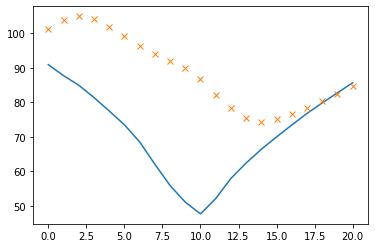

In [8]:
## visualising the q values
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/oned/dqs_3_old', no_actions = 21)
q_arr = []
q_arr.append(dqs.predict_q([0.0, 0]))
print(q_arr[0])

q_arr.append(dqs.predict_q([0.0, 0.5]))

plt.plot(np.arange(0, len(q_arr[0]-1)), q_arr[0])
plt.plot(np.arange(0, len(q_arr[0]-1)), q_arr[1], 'x')
plt.show()

In [6]:
# This block shows simulation of the dq stepper
no_steps = 20 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [0, 0, 1], no_actions=21)

state = env.reset_env([0.0, 0.5], no_steps*step_time)
epi_cost = 0
history = {"state" : [], "q_value" : []}
for n in range(no_steps):
    action, q_value = dqs.predict_action_value(state)
    print(action)
    next_state, cost, done = env.step_env(action, step_time)
    history["q_value"].append(dqs.predict_q(state))
    history["state"].append(state)
    state = np.around(next_state, 2)
    epi_cost += cost
    if done:
        break
print(epi_cost)
print("showing simulation...")  
# env.show_episode(5, 1)


14
14
13
8
10
10
10
10
16
15
14
7
10
10
10
10
10
14
14
15
11.0
showing simulation...


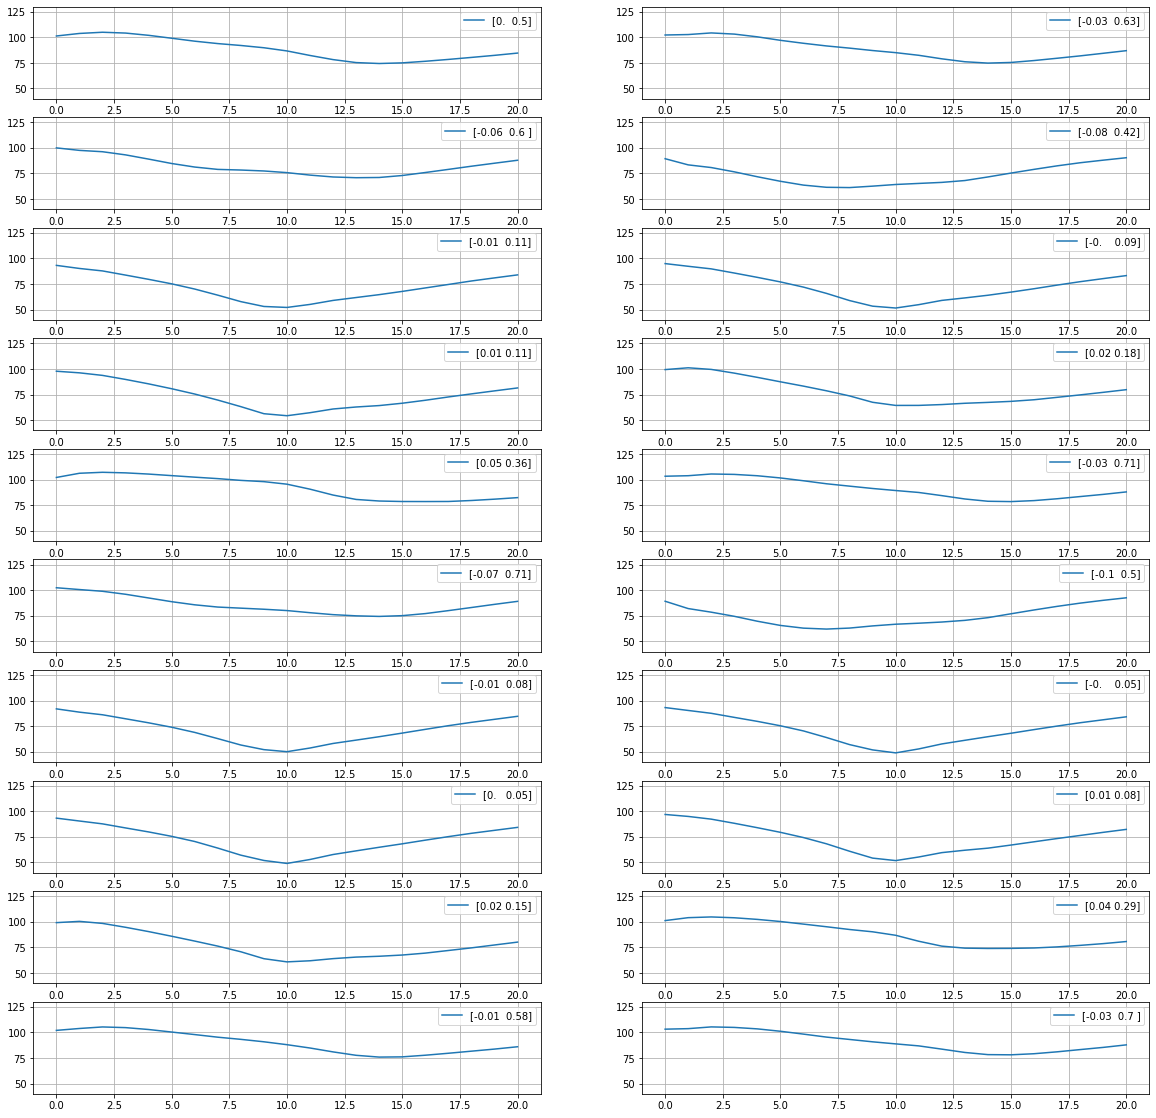

In [54]:
# This block is for visualising the q values for the above stepping simulation
def plot(history):
    fig, axs = plt.subplots(int(no_steps/2), 2, figsize = [20, 20])
    for i in range(int(no_steps/2)):
        axs[i, 0].plot(history["q_value"][2*i], label = str(history["state"][2*i]))
        axs[i, 1].plot(history["q_value"][2*i + 1], label = str(history["state"][2*i + 1]))
        axs[i, 0].set_ylim(40, 130)
        axs[i, 1].set_ylim(40, 130)
        axs[i, 0].legend()    
        axs[i, 1].legend()    
        axs[i, 0].grid()
        axs[i, 1].grid()
    plt.show()

plot(history)

In [5]:
## This block is to test the stepper in simulation with solo
kp = [100, 100, 100]
kd = [1, 1, 5]
kp_com = [0, 0, 100]
kd_com = [5, 5, 30]
kp_ang_com = [300, 300, 300]
kd_ang_com = [100, 100, 100]

step_time = 0.1
ht = 0.2
des_com = [0.2, 0, ht]
des_vel = [0, 0, 0]
x_ori = [0, 0, 0, 1]
x_angvel = [0, 0, 0]


solo_env = SoloBulletEnv(ht, step_time, kp, kd, kp_com, kd_com, kp_ang_com, kd_ang_com)

env = LipmEnv(0.2, 0.22, [2, 2, 0], no_actions=21)
action_space = env.action_space
action = [0, 0]


In [24]:
x, xd, u = solo_env.reset_env()
no_steps = 20
state_x = [x[0] - u[0], xd[0]]
state_y = [x[1] - u[1], xd[1]]

history_x = {"state" : [], "q_value" : []}
history_y = {"state" : [], "q_value" : []}

des_vel = [0.5, 0.0, 0.0]
solo_env.update_gains(kp, kd, [0, 0, 100], [50, 50, 50], [500, 500, 500], [300, 300, 300])
for n in range(no_steps):
    action[0] = action_space[dqs.predict_action_value(state_x)[0]] + u[0]
    action[1] = action_space[dqs.predict_action_value(state_y)[0]] + u[1]
    print(action_space[dqs.predict_action_value(state_y)[0]])
    x, xd, u = solo_env.step_env(action, des_com, des_vel, x_ori, x_angvel)
    history_x["q_value"].append(dqs.predict_q(state_x))
    history_x["state"].append(state_x)
    history_y["q_value"].append(dqs.predict_q(state_y))
    history_y["state"].append(state_y)
    state_x = np.around([x[0] - u[0], xd[0]], 2)
    state_y = np.around([x[1] - u[1], xd[1]], 2)
    

-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
-2.7755575615628914e-17
0.10999999999999996
-2.7755575615628914e-17
-2.7755575615628914e-17
-0.198
-0.198
0.19799999999999998
0.17599999999999996
-0.02200000000000002
-0.02200000000000002
-2.7755575615628914e-17


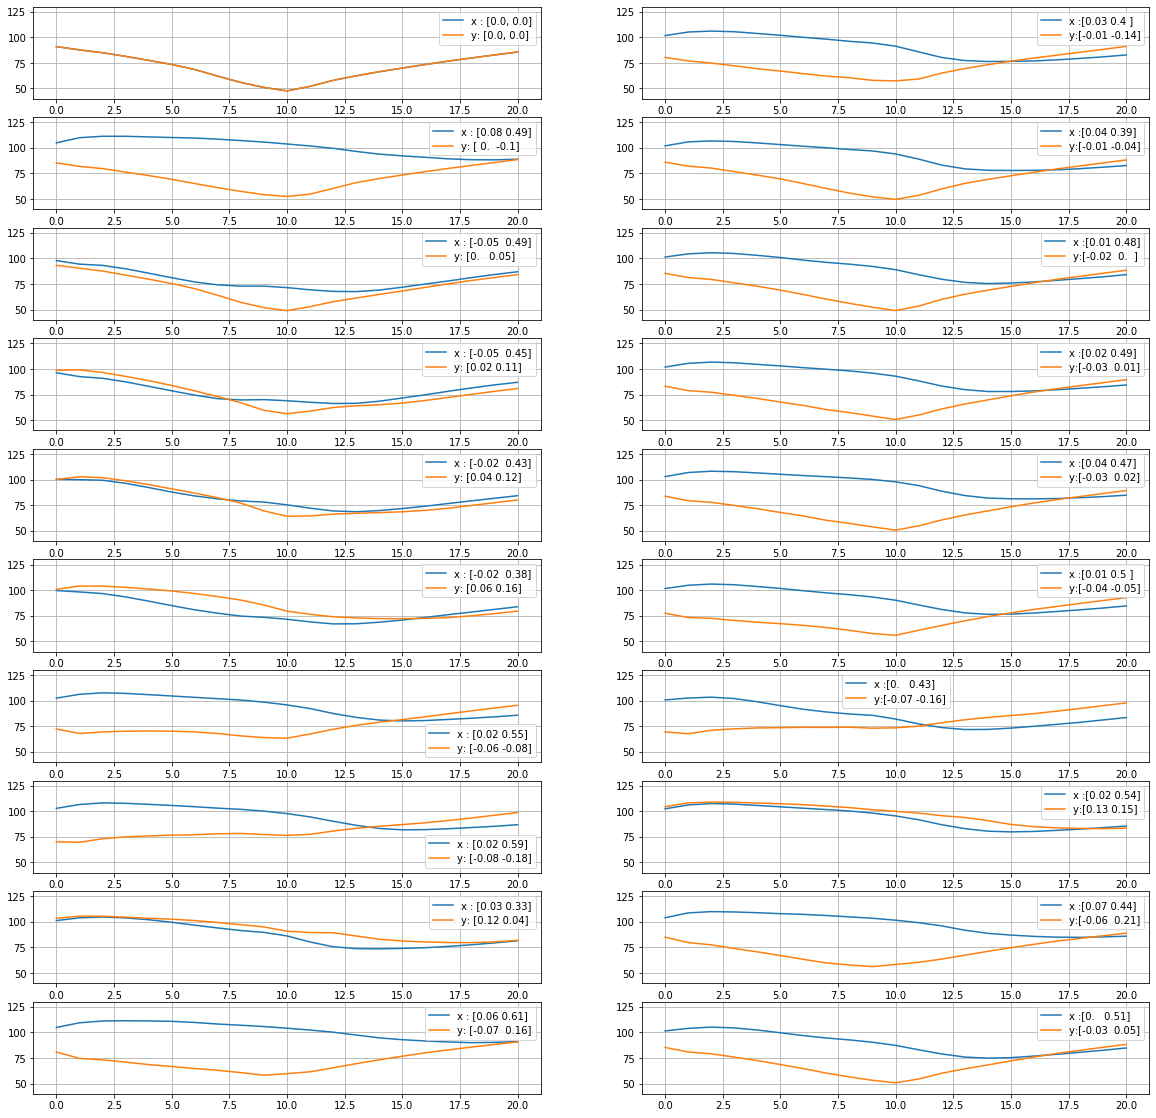

In [25]:
# this block is to plot q values for the above pybullet simulation
def plot_x_y_q(history_x, history_y, no_steps, figsize = [20, 20]):
    fig, axs = plt.subplots(int(no_steps/2), 2, figsize = [20, 20])
    for i in range(int(no_steps/2)):
        axs[i, 0].plot(history_x["q_value"][2*i], label = "x : " +str(history_x["state"][2*i]))
        axs[i, 1].plot(history_x["q_value"][2*i + 1], label = "x :" + str(history_x["state"][2*i + 1]))
        axs[i, 0].plot(history_y["q_value"][2*i], label = "y: " + str(history_y["state"][2*i]))
        axs[i, 1].plot(history_y["q_value"][2*i + 1], label = "y:" + str(history_y["state"][2*i + 1]))

        axs[i, 0].set_ylim(40, 130)
        axs[i, 1].set_ylim(40, 130)
        axs[i, 0].legend()    
        axs[i, 1].legend()    
        axs[i, 0].grid()
        axs[i, 1].grid()

    plt.show()
    
plot_x_y_q(history_x, history_y, no_steps)

In [26]:
# THis block tries to regularize step locations
x, xd, u = solo_env.reset_env()
no_steps = 20
state_x = [x[0] - u[0], xd[0]]
state_y = [x[1] - u[1], xd[1]]

w1 = 20
w2 = 1
history_x = {"state" : [], "q_value" : []}
history_y = {"state" : [], "q_value" : []}

des_vel = [0.5, 0.0, 0.0]
solo_env.update_gains(kp, kd, [0, 0, 100], [50, 50, 50], [500, 500, 500], [300, 300, 300])
# solo_env.start_recording("stepping_demo_regulated")
for n in range(no_steps):
    q_value_x = (np.add(w1*abs(action_space), w2*dqs.predict_q(state_x).T)).T
    q_value_y = (np.add(w1*abs(action_space), w2*dqs.predict_q(state_y).T)).T
    action[0] = action_space[np.argmin(q_value_x)] + u[0]
    action[1] = action_space[np.argmin(q_value_y)] + u[1]
    x, xd, u = solo_env.step_env(action, des_com, des_vel, x_ori, x_angvel)
    history_x["q_value"].append(q_value_x)
    history_x["state"].append(state_x)
    history_y["q_value"].append(q_value_y)
    history_y["state"].append(state_y)
    state_x = np.around([x[0] - u[0], xd[0]], 2)
    state_y = np.around([x[1] - u[1], xd[1]], 2)
# solo_env.stop_recording()

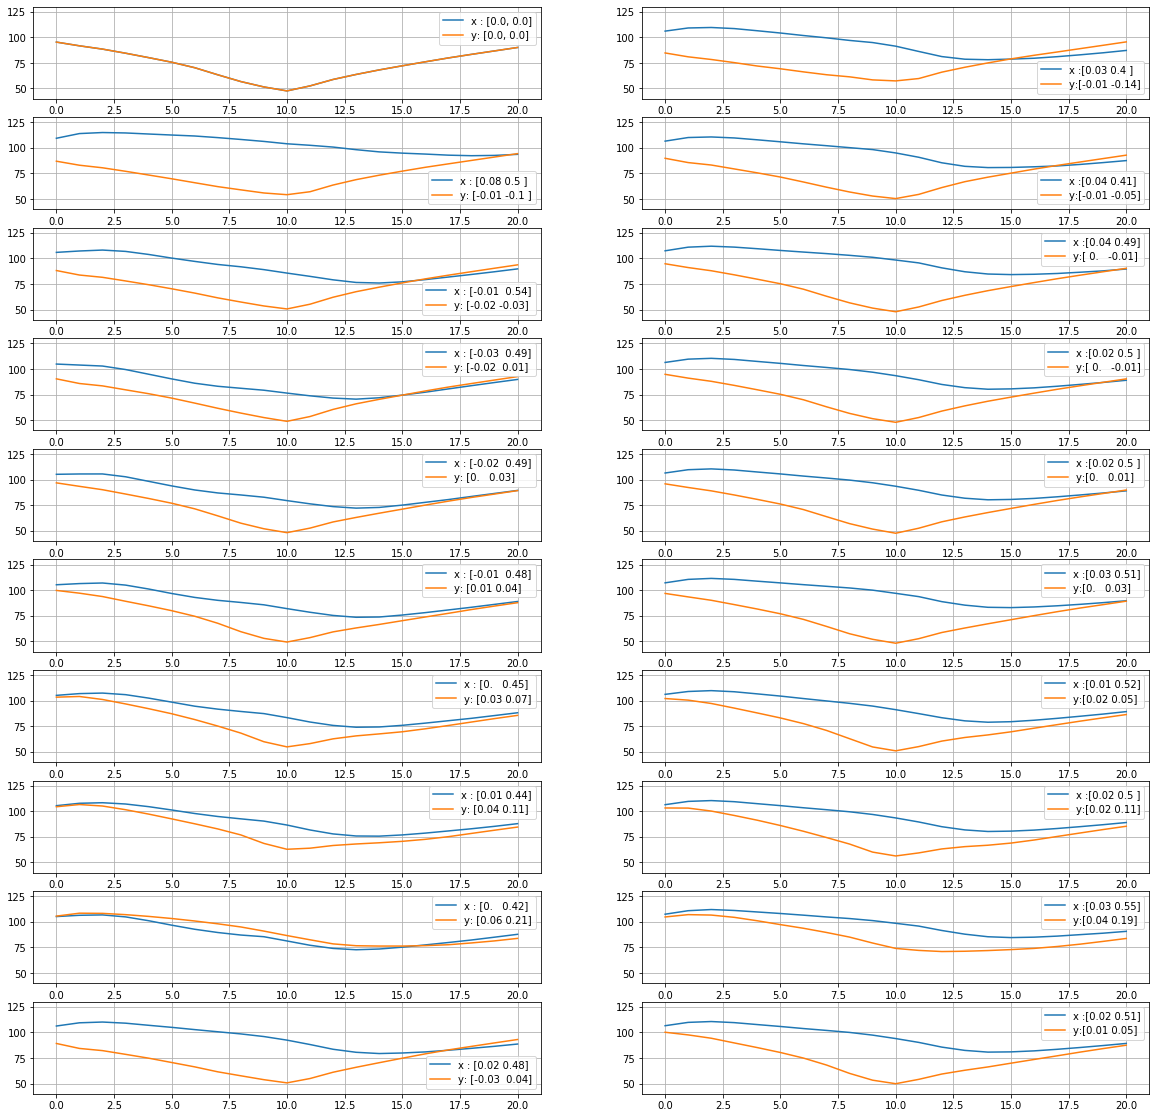

In [27]:
plot_x_y_q(history_x, history_y, no_steps, figsize = [30, 80])
